# Problem Statement

**What we plan to do**

There are many variables that determine how much a home can fetch. 

Using the Ames (IA) dataset (```train```, ```test```), we want to find out which variables matter for home saleprices and produce accurate saleprice predictions. 

**What type of models will we be exploring?**

We will be focusing our project on supervised machine learning models. Linear models and regularization are areas of particular interest for us.

**How will success be evaluated?**

We will focus on optimising $R^2$, as well as **RMSE** across different models. Our aim is to create a model that significantly outperforms the baseline heuristic which we've identified.

**Is this the scope of the project appropriate? Who are our important stakeholders and why is this important to investigate?**

This model will provide the *Outside View*, helping to reduce information asymmetry between potential home-buyers, home-sellers and real estate agents.

An Outside View* involves ignoring these details and using an estimate based on a class of roughly similar previous cases. Your Inside View involves making predictions based on your understanding of the details of the process - not that it’s wrong, it’s just that it’s often biased!

*Excerpt from Daniel Kahneman - Thinking Fast and Slow: The outside view asks if there are similar situations that can provide a statistical basis for making a decision. Rather than seeing a problem as unique, the outside view wants to know if others have faced comparable problems and, if so, what happened*

# Data-cleaning and EDA

In [1]:
# Importing the neccessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, PowerTransformer
from sklearn import metrics
from sklearn.impute import KNNImputer

In [2]:
# Ensuring the notebook remains tidy
import warnings
warnings.filterwarnings('ignore') # Ensuring our notebook remains tidy

In [3]:
# Setting up my charts
sns.set_style('darkgrid')

In [4]:
# Import train dataset
train = pd.read_csv('./datasets/train.csv')

In [5]:
# Let's take a quick look at the training dataset's dimensions
train.shape

(2051, 81)

In [6]:
# Import test dataset
test = pd.read_csv('./datasets/test.csv')

In [7]:
# Let's take a quick look at the test dataset's dimensions
## We should see one less column because 'saleprice' is the target we are trying to predict
test.shape

(878, 80)

*Note*: There should be 1 column less in ```test``` vs. ```train```

In [8]:
# Taking a quick look at test size
test.shape[0] / (test.shape[0] + train.shape[0])

0.299761010583817

*Note*: The test dataset is approximately 30% that of the train dataset

In [9]:
# Let's make our life easier by tidying the column names
def tidy_columns(df):
    tidied_name = {}
    for col in df.columns:
        tidied_name[col] = col.lower().replace(' ', '_') # Replacing spaces with underscores; Switching to lower case
    
    return df.rename(columns = tidied_name, inplace=True)

In [10]:
# Tidying train dataset colunms - Converting column names to lowercase
tidy_columns(train)
tidy_columns(test)

In [11]:
# Notice that there are variables for year sold, month sold, year where a particular feature of a house was built
# We can calculate age ... which will make for more meaningful analysis
train['age_remodel'] = train['yr_sold'] - train['year_remod/add']
train['age_home'] = train['yr_sold'] - train['year_built']
# train['age_garage'] = train['yr_sold'] - train['garage_yr_blt']

# Replicate for test set
test['age_remodel'] = test['yr_sold'] - test['year_remod/add']
test['age_home'] = test['yr_sold'] - test['year_built']
# test['age_garage'] = test['yr_sold'] - test['garage_yr_blt']

*Note*: We've decided not to calculate the age of garages as not all houses have garages. This can be proxied via the age of the home.

In [12]:
# Let's now drop these columns
train.drop(columns=['yr_sold','garage_yr_blt', 'year_remod/add', 'year_built'], inplace = True)
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,sale_type,saleprice,age_remodel,age_home
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,WD,130500,5,34
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,WD,220000,12,13
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,WD,109000,3,57
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,WD,174000,3,4
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,WD,138500,17,110


In [13]:
# Check test dataset
test.drop(columns=['yr_sold','garage_yr_blt', 'year_remod/add', 'year_built'], inplace = True)
test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,sale_type,age_remodel,age_home
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,WD,56,96
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,WD,29,29
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,New,0,0
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,WD,1,84
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,185,0,NaN,NaN,NaN,0,7,WD,46,46


In [14]:
# A quick overview of our train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

In [15]:
# Selecting all qualitative columns
qual_cols = train.select_dtypes(include='object').columns
print(f'There are {len(qual_cols)} qualitative columns vs. {len(train.columns) - len(qual_cols)} quantitative columns')

There are 42 qualitative columns vs. 37 quantitative columns


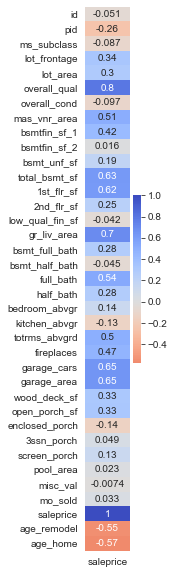

In [16]:
# Let's first take a quick look at the correlations of various quantitative features with saleprice
matrix = train.corr()
plt.subplots(figsize=(1,10))
sns.heatmap(matrix[['saleprice']], cmap='coolwarm_r', center=0, annot=True)
plt.show()

Based on the correlation matrix we've plotted above, we can narrow down the list of features to select for our model. We'll go with a threshold of > |0.29|

Overall quality appears to have the highest correlation with saleprice. Recall that we do have ```external_qual, kitchen-qual, bsmt_qual, garage_qual``` as qualitative features. Since they are ordinal features, we could manually convert them to a numerical scale.

*Note*: We will take care of missing values for the test dataset later

**We have decided not to convert these qualitative columns into ordinal numerical features as they assume a somewhat linear relationship in quality and price. Results were also poorer after testing**

In [17]:
feat = matrix['saleprice'].sort_values(ascending=False)

# Subset features with absolute correlations >= 0.25 to around 0.30
feat_kept = feat[(abs(feat) >= 0.285)]
print(feat_kept)

saleprice        1.000000
overall_qual     0.800207
gr_liv_area      0.697038
garage_area      0.650270
garage_cars      0.648220
total_bsmt_sf    0.628925
1st_flr_sf       0.618486
full_bath        0.537969
mas_vnr_area     0.512230
totrms_abvgrd    0.504014
fireplaces       0.471093
bsmtfin_sf_1     0.423519
lot_frontage     0.341842
open_porch_sf    0.333476
wood_deck_sf     0.326490
lot_area         0.296566
age_remodel     -0.551716
age_home        -0.571881
Name: saleprice, dtype: float64


*Note*: We want to include ```lot_area``` but exclude ```pid```. See how age of home and time since remodeling have decent negative correlations with saleprice (i.e. The newer a home is, the more expensive it is)

**Are adequate summary statistics provided?**

Here's a quick snapshot of our quantitative features in our train dataset.

In [18]:
# Quick overview of selected features
train[list(feat_kept.index)].describe()

,saleprice,overall_qual,gr_liv_area,garage_area,garage_cars,total_bsmt_sf,1st_flr_sf,full_bath,mas_vnr_area,totrms_abvgrd,fireplaces,bsmtfin_sf_1,lot_frontage,open_porch_sf,wood_deck_sf,lot_area,age_remodel,age_home
count,2051.000000,2051.000000,2051.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2029.000000,2051.000000,2051.000000,2050.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,181469.701609,6.112140,1499.330083,473.671707,1.776585,1057.987805,1164.488055,1.577279,99.695909,6.435885,0.590931,442.300488,69.055200,47.556802,93.833740,10065.208191,23.585568,36.066797
std,79258.659352,1.426271,500.447829,215.934561,0.764537,449.410704,396.446923,0.549279,174.963129,1.560225,0.638516,461.204124,23.260653,66.747241,128.549416,6742.488909,21.021078,30.211061
min,12789.000000,1.000000,334.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,2.000000,0.000000,0.000000,21.000000,0.000000,0.000000,1300.000000,-2.000000,-1.000000
25%,129825.000000,5.000000,1129.000000,319.000000,1.000000,793.000000,879.500000,1.000000,0.000000,5.000000,0.000000,0.000000,58.000000,0.000000,0.000000,7500.000000,4.000000,7.000000
50%,162500.000000,6.000000,1444.000000,480.000000,2.000000,994.500000,1093.000000,2.000000,0.000000,6.000000,1.000000,368.000000,68.000000,27.000000,0.000000,9430.000000,15.000000,34.000000
75%,214000.000000,7.000000,1728.500000,576.000000,2.000000,1318.750000,1405.000000,2.000000,161.000000,7.000000,1.000000,733.750000,80.000000,70.000000,168.000000,11513.500000,43.000000,54.000000
max,611657.000000,10.000000,5642.000000,1418.000000,5.000000,6110.000000,5095.000000,4.000000,1600.000000,15.000000,4.000000,5644.000000,313.000000,547.000000,1424.000000,159000.000000,60.000000,136.000000


Having a look at min/max values relative to different percentiles can give us a good idea of whether there are any outliers in our ```train``` dataset.

Comparing where the mean lies relative to the median for our quantitative variables should give us a good sense of whether the dataset is left / right skewed and how much kurtosis there is. **We will provide a visual representation of distributions once we've tidied the data.**

But first... let's check out if there are any missing values from our dataset

## Imputing / dropping missing values

### Addressing our train set

In [19]:
# Identifying features with many values
missing = train.isna().mean()
missing_sub = missing[missing>0.2] # Our threshold is 20%
missing_sub

alley           0.931741
fireplace_qu    0.487567
pool_qc         0.995612
fence           0.804973
misc_feature    0.968308
dtype: float64

In [20]:
# Dropping columns with more than 20% of values missing
train.drop(columns = list(missing_sub.index), inplace=True)

<AxesSubplot:>

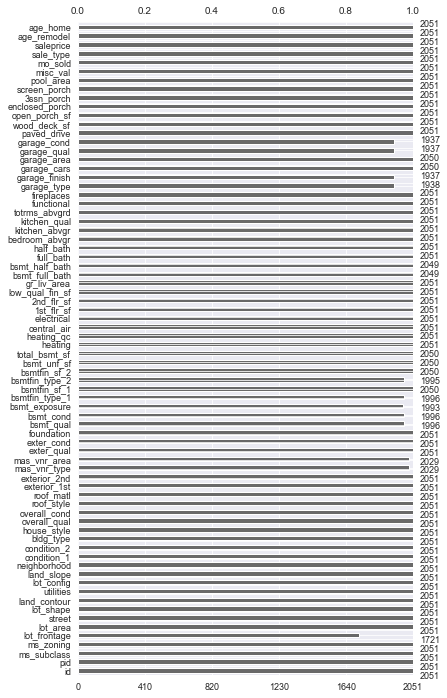

In [21]:
# Let's visualize whether our train dataset is missing any other features
msno.bar(train, figsize=(6,12), fontsize=9)

Several quantitative features like garage_area, garage_cars, mas_vnr_area, total_bsmt_sf, bsmtfin_sf_1, lot_frontage, age_garage are missing values. These do not appear to be missing at random.

Same goes for qualitative features - which will address later

<AxesSubplot:>

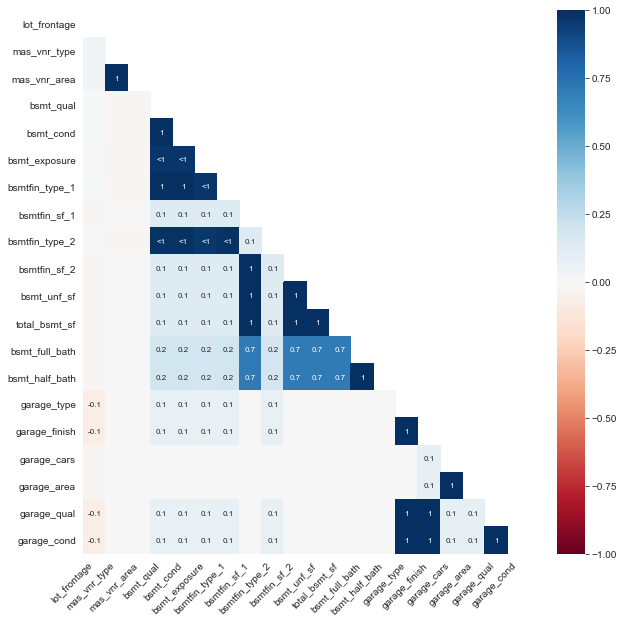

In [22]:
# Are these missing features somewhat correlated?
msno.heatmap(train, figsize=(10,10), fontsize=10)

1. ```garage_cars``` and ```garage_area``` have a correlation of 1; Garage area is probably zero (i.e. No garage) hence there's no space for cars
2. ```bsmtfin_sf_1``` and ```total_bsmt_sf``` also have a correlation of 1; Observation probably does not have any basement

**Are missing values imputed appropriately?**

There are significant price differences across houses in different neighbourhoods. That is why we've decided to impute missing values in ```lot_frontages``` with the median lot frontage for each neighbourhood.

In [23]:
## Let's tidy lot_frontage using the median corresponding to the dataset
imputed_lot_front_train = {}
for neighborhood in train['neighborhood'].unique():
    imputed_lot_front_train[neighborhood] = train[train['neighborhood'] == neighborhood]['lot_frontage'].median()

In [24]:
## Let's imput the medians into the NaN values
train['lot_frontage'][train['lot_frontage'].isnull()] = train['neighborhood'][train['lot_frontage'].isnull()].map(imputed_lot_front_train)

In [25]:
# There's not much data for these so let's strip them out
train.loc[train['lot_frontage'].isnull(), ['neighborhood', 'lot_frontage']]

,neighborhood,lot_frontage
463,GrnHill,NaN
1121,Landmrk,NaN
1211,GrnHill,NaN


In [26]:
train = train[(train['neighborhood'] != 'GrnHill') & (train['neighborhood'] != 'Landmrk')]

In [27]:
# # There's also some missing values for age_garage
# train.loc[train['age_garage'].isnull(), 'age_garage'] = 0

For missing values in ```garage_cars```, ```garage_area```, ```total_bsmt_sf```, ```bsmtfin_sf_1```, ```bsmt_unf_sf```, we can impute them with 0 (See correlation plot of missing values above)

In [28]:
# There's also some missing values for garage_cars and garage_area; We can assume this to be zero
train.loc[train['garage_cars'].isnull(), ['garage_cars', 'garage_area']] = 0

In [29]:
# There's also some missing values for total_bsmt_sf and bsmtfin_sf_1; We can assume this to be zero
train.loc[train['total_bsmt_sf'].isnull(), ['total_bsmt_sf', 'bsmtfin_sf_1', 'bsmt_unf_sf']] = 0

In [30]:
# There's also some missing values for mas_vnr_area; We can assume this to be zero
train.loc[train['mas_vnr_area'].isnull(), ['mas_vnr_area']] = 0

In [31]:
# Check train dimensions
train.shape

(2048, 74)

## Visualising outliers

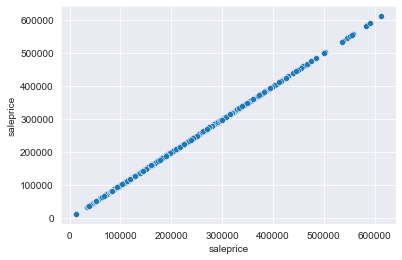

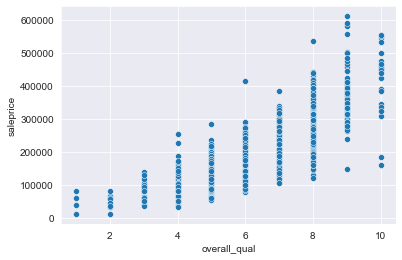

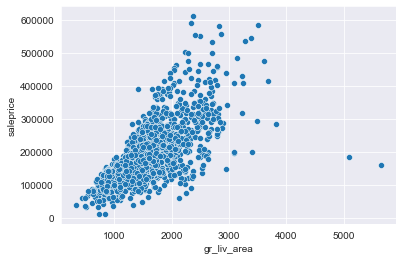

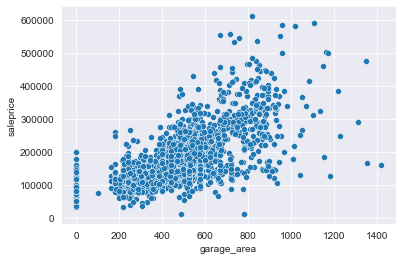

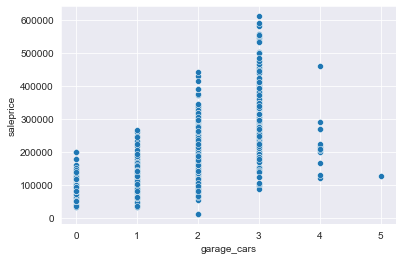

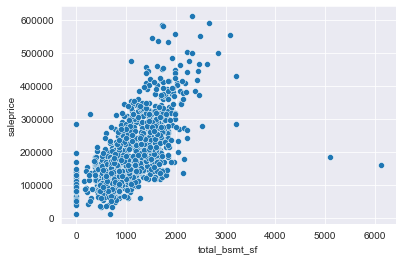

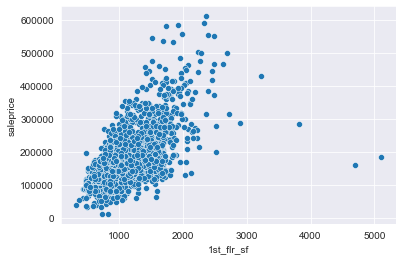

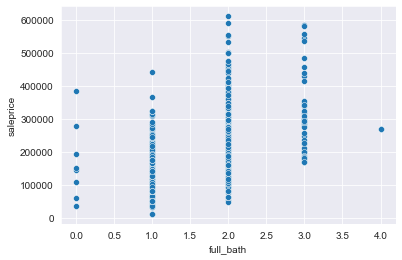

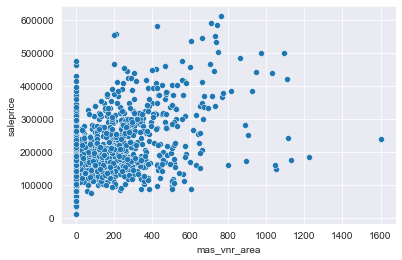

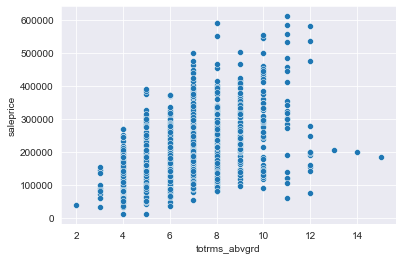

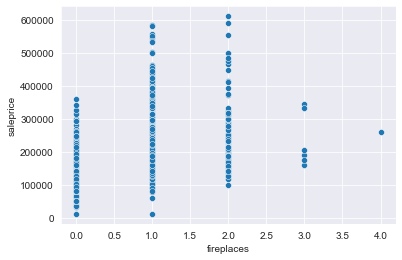

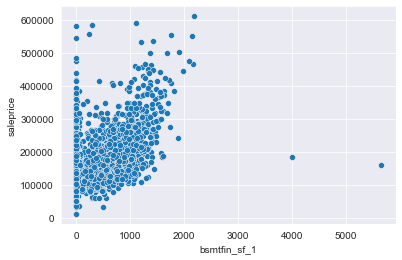

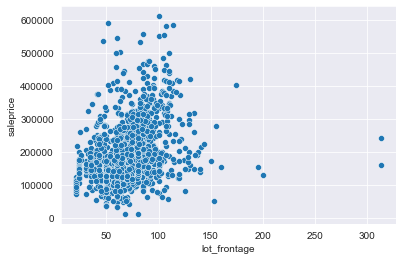

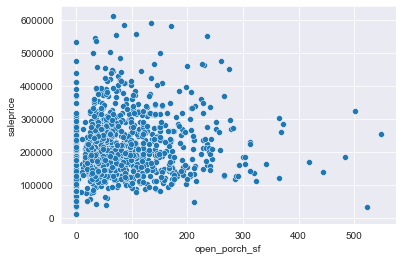

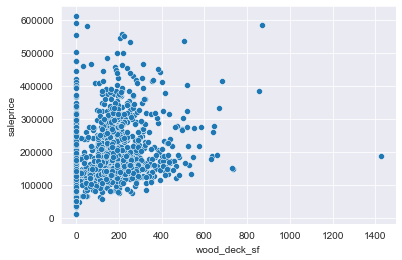

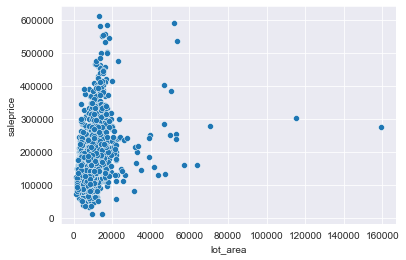

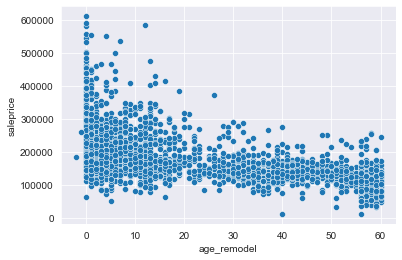

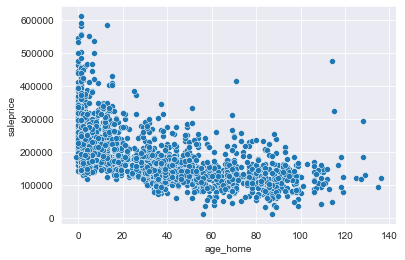

In [32]:
# Quick statiscal snapshot of our features
for col in list(feat_kept.index):
    sns.scatterplot(data=train, x=col, y='saleprice')
    plt.show()

## Dropping outliers from quantitative features

**Are outliers identified and addressed?**

After visually inspecting the scatterplots (saleprice vs. features), we have decided to drop some outliers from the following features:

In [33]:
train = train[(train['1st_flr_sf'] <=3000)]

In [34]:
train = train[(train['lot_area'] <=80000)]

In [35]:
train = train[(train['lot_frontage'] <=300)]

In [36]:
train = train[(train['mas_vnr_area'] <=1400)]

In [37]:
train = train[(train['wood_deck_sf'] <=1000)]

In [38]:
train = train[(train['open_porch_sf'] <=400)]

In [39]:
train = train[(train['gr_liv_area'] <=4000)]

In [40]:
# train = train[(train['age_garage'] >=0)]

In [41]:
train = train[(train['total_bsmt_sf'] <=4000)]

In [42]:
# train = train[(train['garage_cars'] < 5)]

In [43]:
# Select all qualitative
qual_cols = train.select_dtypes(include='object').columns

In [44]:
# Are there any missing values for our qualitative data?
train[qual_cols].isna().sum()

ms_zoning           0
street              0
lot_shape           0
land_contour        0
utilities           0
lot_config          0
land_slope          0
neighborhood        0
condition_1         0
condition_2         0
bldg_type           0
house_style         0
roof_style          0
roof_matl           0
exterior_1st        0
exterior_2nd        0
mas_vnr_type       22
exter_qual          0
exter_cond          0
foundation          0
bsmt_qual          53
bsmt_cond          53
bsmt_exposure      56
bsmtfin_type_1     53
bsmtfin_type_2     54
heating             0
heating_qc          0
central_air         0
electrical          0
kitchen_qual        0
functional          0
garage_type       112
garage_finish     113
garage_qual       113
garage_cond       113
paved_drive         0
sale_type           0
dtype: int64

There's some missing data with regard to features concerning the basement, which makes sense since not all houses have basements. Missing data concerning masonry types and garages can also be ignored

In [45]:
# Missing values matter a lot for quantitative data
# Let's check our quantitative dataset
train[feat_kept.index].isnull().sum()

saleprice        0
overall_qual     0
gr_liv_area      0
garage_area      0
garage_cars      0
total_bsmt_sf    0
1st_flr_sf       0
full_bath        0
mas_vnr_area     0
totrms_abvgrd    0
fireplaces       0
bsmtfin_sf_1     0
lot_frontage     0
open_porch_sf    0
wood_deck_sf     0
lot_area         0
age_remodel      0
age_home         0
dtype: int64

In [46]:
list_qual_cols = list(qual_cols)

## Addressing qualitative features

We can technically see if categorical features have a significant impact on saleprice by visually inspecting the boxplots below. 

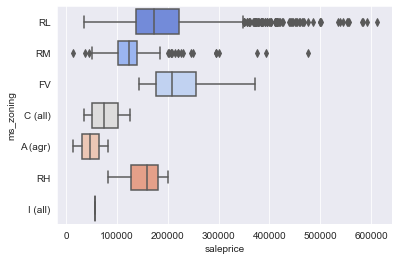

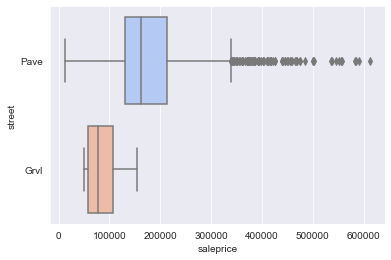

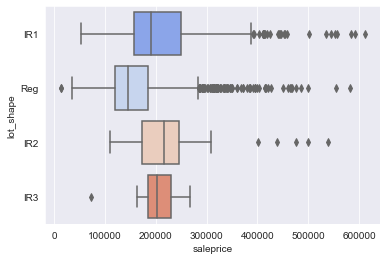

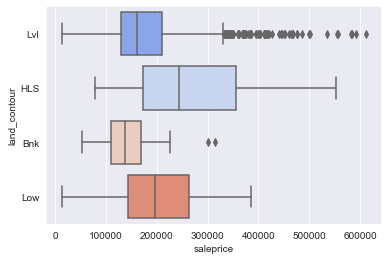

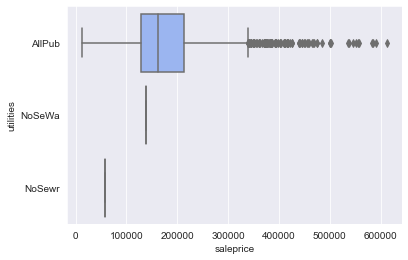

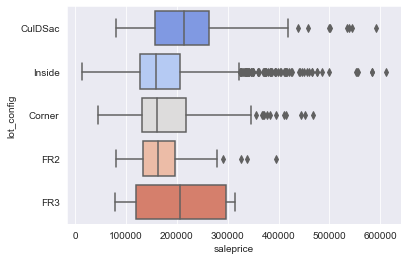

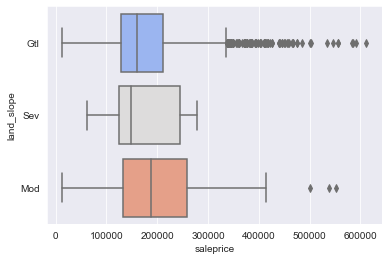

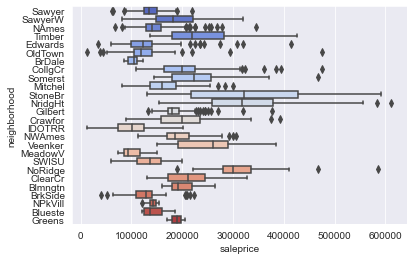

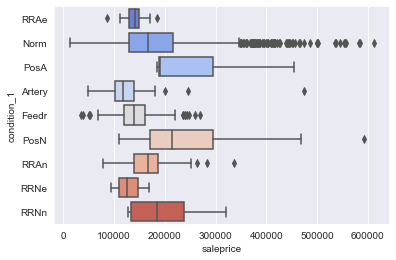

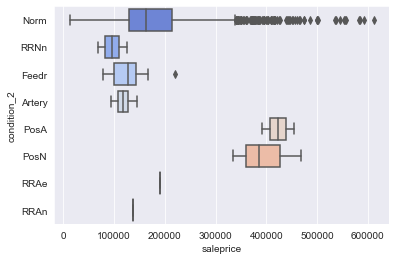

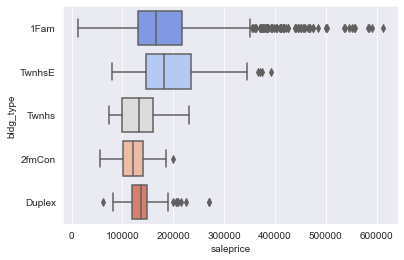

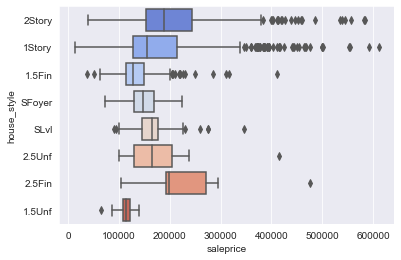

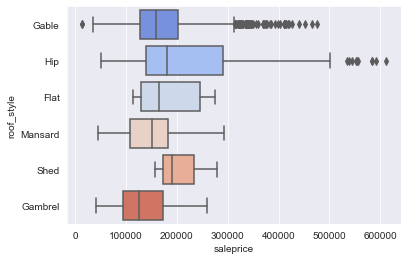

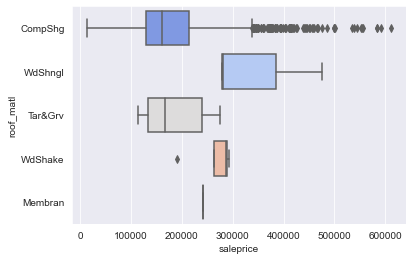

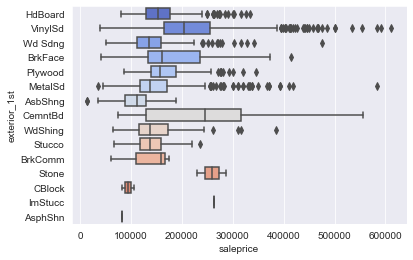

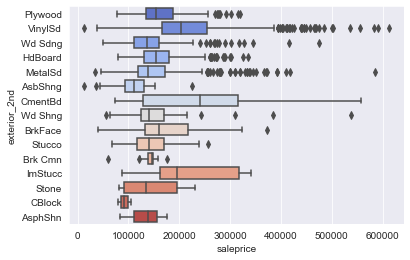

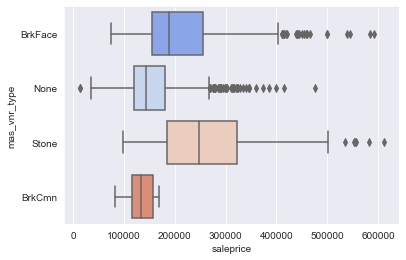

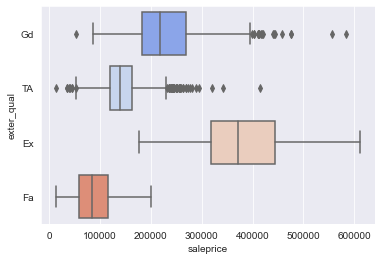

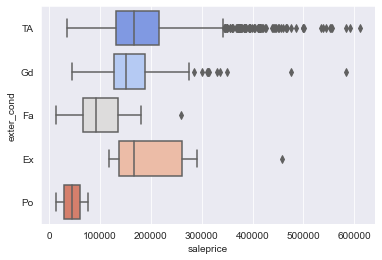

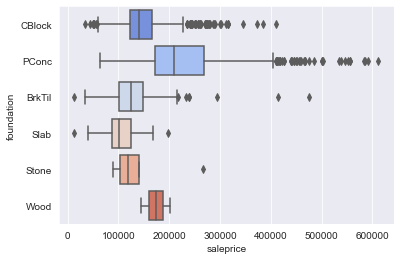

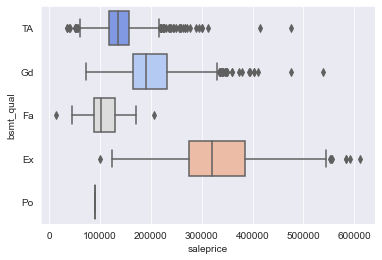

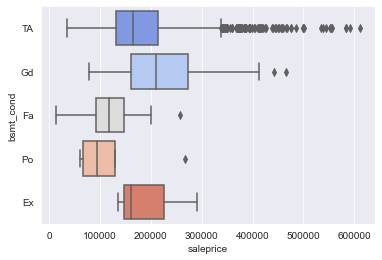

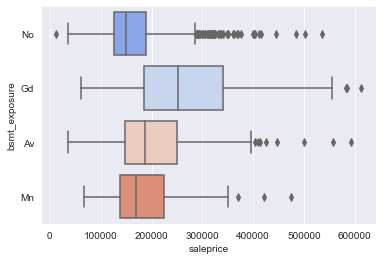

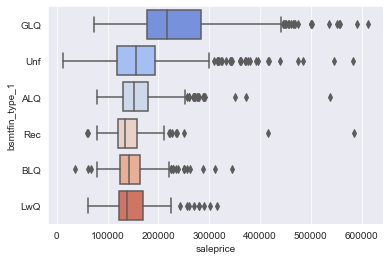

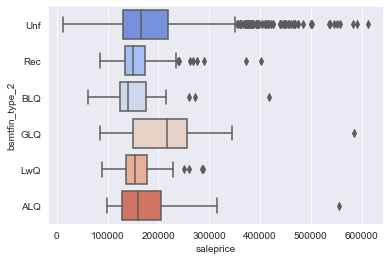

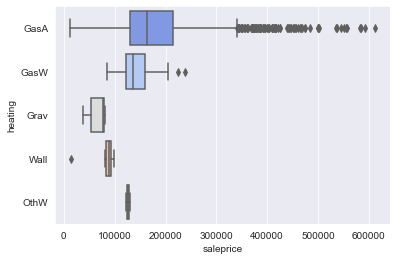

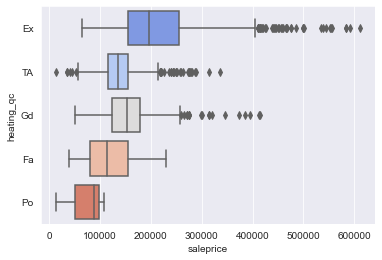

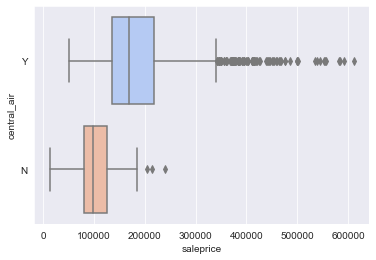

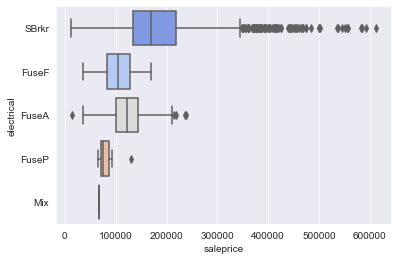

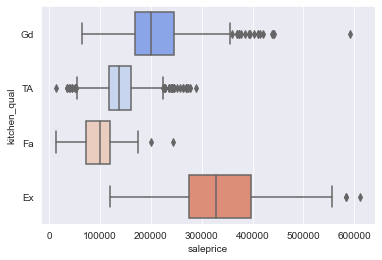

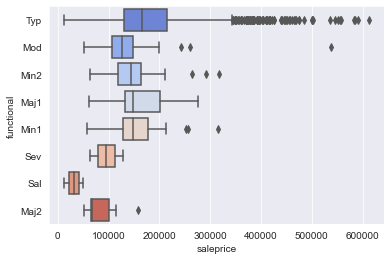

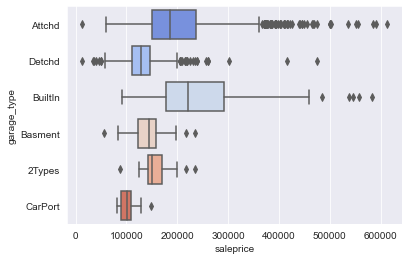

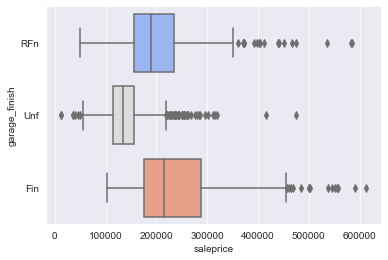

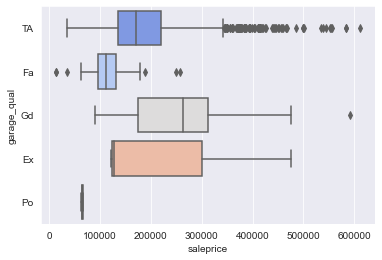

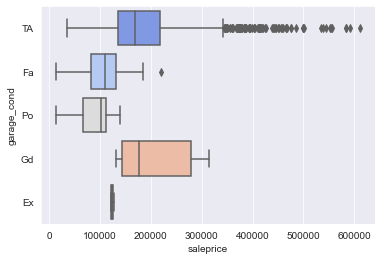

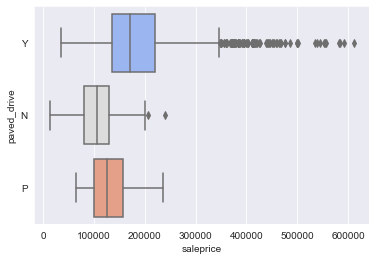

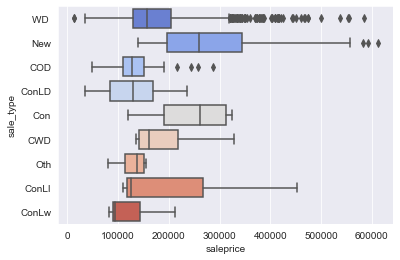

In [47]:
for col in list(qual_cols):
    sns.boxplot(data=train, y=col, x='saleprice', palette='coolwarm')
    plt.show()

In [48]:
to_remove = ['ms_zoning', 'lot_shape', 'utilities', 'roof_style', 'heating', 
             'electrical','lot_config', 'land_slope', 'paved_drive']
qual_cols = qual_cols.drop(to_remove)

In [49]:
combined_feats = list(feat_kept.index) + list(qual_cols)

## Imputing missing values in qualitative features

### Tidying our train dataset

In [50]:
# Sub-setting our train dataset
train_trimmed = train[combined_feats]

In [51]:
train_trimmed.loc[train_trimmed['mas_vnr_type'].isnull(), 'mas_vnr_type'] = 'None'

In [52]:
# Removing 'saleprice' from the list of features
combined_feats.remove('saleprice')

### Tidying our test dataset

In [53]:
#Sub-setting our test dataset
test_trimmed = test[combined_feats]

In [54]:
list_of_test_nulls = test_trimmed.isnull().sum()
list_of_test_nulls[list_of_test_nulls > 0]

mas_vnr_area        1
lot_frontage      160
mas_vnr_type        1
bsmt_qual          25
bsmt_cond          25
bsmt_exposure      25
bsmtfin_type_1     25
bsmtfin_type_2     25
garage_type        44
garage_finish      45
garage_qual        45
garage_cond        45
dtype: int64

Since lot_frontage are affected by where you live (aka. neighbourhood), we can impute missing data by using the median of its respective neighbourhood.

In [55]:
## Let's tidy lot_frontage using the median corresponding to the dataset
imputed_lot_front = {}
for neighborhood in test_trimmed['neighborhood'].unique():
    imputed_lot_front[neighborhood] = test_trimmed[test_trimmed['neighborhood'] == neighborhood]['lot_frontage'].mean()

In [56]:
## Let's imput the medians into the NaN values
test_trimmed['lot_frontage'][test_trimmed['lot_frontage'].isnull()] = test_trimmed['neighborhood'][test_trimmed['lot_frontage'].isnull()].map(imputed_lot_front)

In [57]:
# There's also some missing values for age_garage
# test_trimmed.loc[test_trimmed['age_garage'].isnull(), 'age_garage'] = 0

If there are missing values for ```mas_vnr_area```, we can assume that particular house does not have any masonry veneers. This will also apply towards ```mas_vnr_type```.

In [58]:
# There's also some missing values for mass_vnr_area
test_trimmed.loc[test_trimmed['mas_vnr_area'].isnull(), 'mas_vnr_area'] = 0

In [59]:
# There's also some missing values for mass_vnr_type
test_trimmed.loc[test_trimmed['mas_vnr_type'].isnull(), 'mas_vnr_type'] = 'None'

In [60]:
# # There's also some missing values for bsmt_qual
# test_trimmed.loc[test_trimmed['bsmt_qual'].isnull(), 'bsmt_qual'] = 0

In [61]:
# # There's also some missing values for garage_qual
# test_trimmed.loc[test_trimmed['garage_qual'].isnull(), 'garage_qual'] = 0

In [62]:
# Lets have a look at missing values from the test set after the imputations
list_of_test_nulls = test_trimmed.isnull().sum()
list_of_test_nulls[list_of_test_nulls > 0]

bsmt_qual         25
bsmt_cond         25
bsmt_exposure     25
bsmtfin_type_1    25
bsmtfin_type_2    25
garage_type       44
garage_finish     45
garage_qual       45
garage_cond       45
dtype: int64

In [63]:
train_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 0 to 2050
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   saleprice       2034 non-null   int64  
 1   overall_qual    2034 non-null   int64  
 2   gr_liv_area     2034 non-null   int64  
 3   garage_area     2034 non-null   float64
 4   garage_cars     2034 non-null   float64
 5   total_bsmt_sf   2034 non-null   float64
 6   1st_flr_sf      2034 non-null   int64  
 7   full_bath       2034 non-null   int64  
 8   mas_vnr_area    2034 non-null   float64
 9   totrms_abvgrd   2034 non-null   int64  
 10  fireplaces      2034 non-null   int64  
 11  bsmtfin_sf_1    2034 non-null   float64
 12  lot_frontage    2034 non-null   float64
 13  open_porch_sf   2034 non-null   int64  
 14  wood_deck_sf    2034 non-null   int64  
 15  lot_area        2034 non-null   int64  
 16  age_remodel     2034 non-null   int64  
 17  age_home        2034 non-null   i

# Data Dictionary

Now that we've tidied and fixed our data, let's create a data dictionary. This will provide a quick overview of features/variables/columns, alongside data types and descriptions. The more descriptive you can be, the more useful this document is.

**train_trimmed**: Cleaned training dataset

|Feature|Type|Description|
|:-|:-:|:-|
|saleprice|int64|The property's sale price in dollars. This is our target variable|
|overall_qual|int64|Overall material and finish quality|
|gr_liv_area|int64|Above grade (ground) living area square feet|
|garage_area|float64|Size of garage in square feet|
|garage_cars|float64|Size of garage in car capacity|
|total_bsmt_sf|float64|Total square feet of basement area|
|1st_flr_sf|int64|First Floor square feet|
|full_bath|int64|Full bathrooms above grade|
|mas_vnr_area|float64|Masonry veneer area in square feet|
|totrms_abvgrd|int64|Total rooms above grade (does not include bathrooms)|
|fireplaces|int64|Number of fireplaces|
|bsmtfin_sf_1|float64|Type 1 finished square feet|
|lot_frontage|float64|Linear feet of street connected to property|
|open_porch_sf|int64|Open porch area in square feet|
|wood_deck_sf|int64|Wood deck area in square feet|
|lot_area|int64|Lot size in square feet|
|age_remodel|int64|Time since remodel (Calculated)|
|age_home|int64|Age of home (Calculated)|
|street|object|Type of road access to property|
|land_contour|object|Flatness of the property|
|neighborhood|object|Physical locations within Ames city limits|
|condition_1|object|Proximity to main road or railroad|
|condition_2|object|Proximity to main road or railroad (if a second is present)|
|bldg_type|object|Type of dwelling|
|house_style|object|Style of dwelling|
|roof_matl|object|Roof material|
|exterior_1st|object|Exterior covering on house|
|exterior_2nd|object|Exterior covering on house (if more than one material)|
|mas_vnr_type|object|Masonry veneer type|
|exter_qual|object|Exterior material quality|
|exter_cond|object|Present condition of the material on the exterior|
|foundation|object|Type of foundation|
|bsmt_qual|object|Height of the basement|
|bsmt_cond|object|General condition of the basement|
|bsmt_exposure|object|Walkout or garden level basement walls|
|bsmtfin_type_1|object|Quality of basement finished area|
|bsmtfin_type_2|object|Quality of second finished area (if present)|
|heating_qc|object|Heating quality and condition|
|central_air|object|Central air conditioning|
|kitchen_qual|object|Kitchen quality|
|functional|object|Home functionality rating|
|garage_type|object|Garage location|
|garage_finish|object|Interior finish of the garage|
|garage_qual|object|Garage quality|
|garage_cond|object|Garage condition|
|sales_type|object|Type of sale|


# Preprocessing

To increase efficiency, we will combine both train and test datasets for pre-processing. This way, we'll be able to capture both train and test datasets' unique features when one-hot encoding them.

In [64]:
# Creating a custom label for both train and test datasets
train_trimmed['source'] = 'train'
test_trimmed['source'] = 'test'

In [65]:
# Concatenating both train and test datasets for more efficient pre-processing
train_test_comb = pd.concat([train_trimmed, test_trimmed], ignore_index=True)

In [66]:
# Define function to get the list of columns for dummy variables
def get_dummy_cols(df):
    dummies = []
    for name in df.columns:
        if (df[name].dtypes == 'object') and (name != 'source'): #They need to be object-type features
            dummies.append(name)
        else:
            pass
    return dummies

In [67]:
# Applying our customized function
cols_to_dum = get_dummy_cols(test_trimmed)

In [68]:
# One-hot-encoding / Dummifying categorical features
train_test_comb_dums = pd.get_dummies(train_test_comb, columns=cols_to_dum, drop_first=True)

In [69]:
# Reverting back to the original train and test datasets
train_d = train_test_comb_dums.loc[train_test_comb_dums['source'] == 'train']
test_d = train_test_comb_dums.loc[train_test_comb_dums['source'] == 'test']

In [70]:
train_d.drop(columns=['source'], inplace=True)
test_d.drop(columns=['source', 'saleprice'], inplace=True)

In [71]:
print(train_d.shape)
print(test_d.shape)

(2034, 187)
(878, 186)


# Modelling

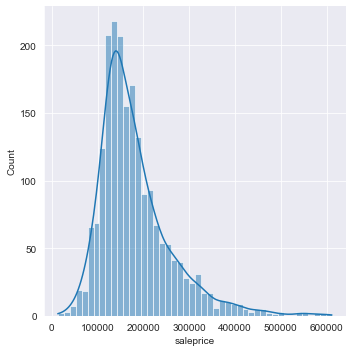

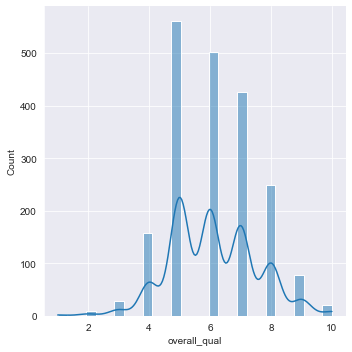

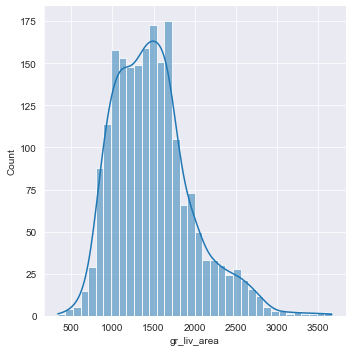

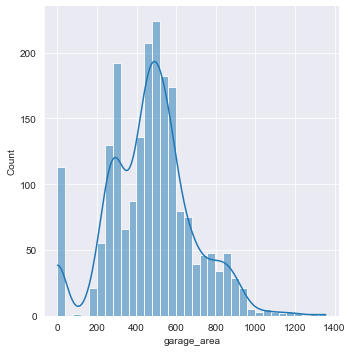

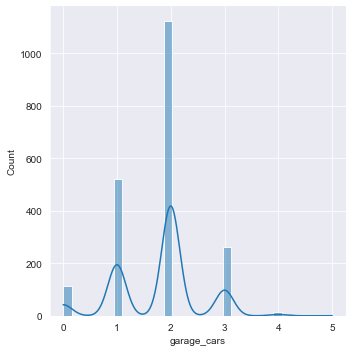

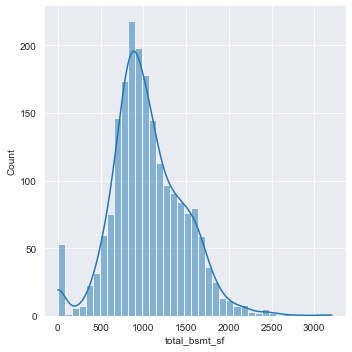

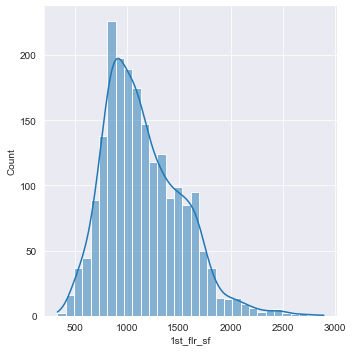

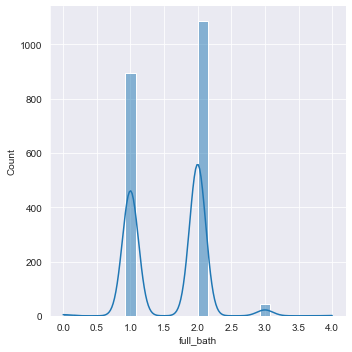

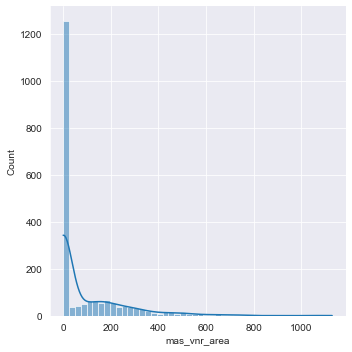

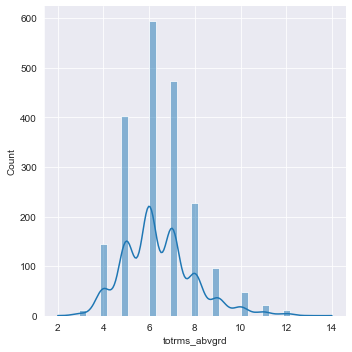

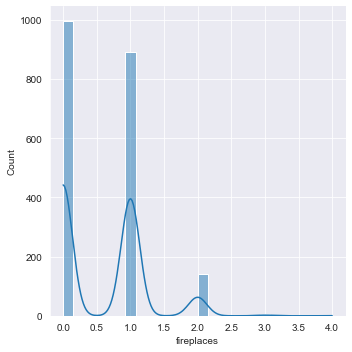

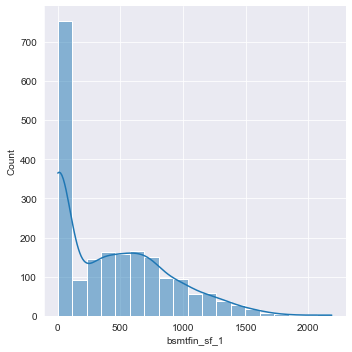

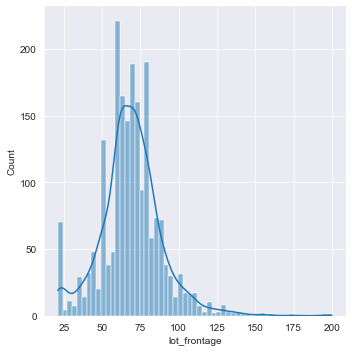

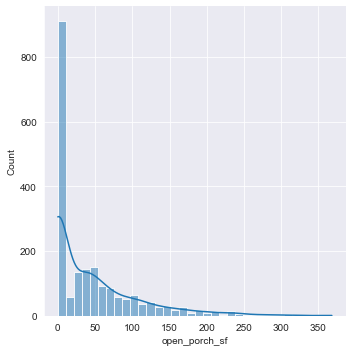

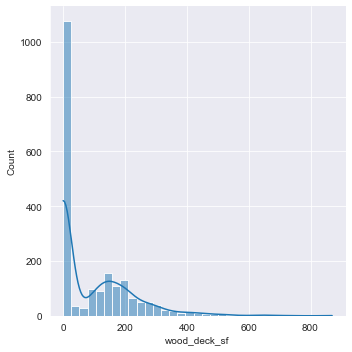

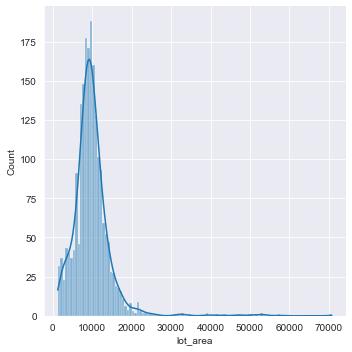

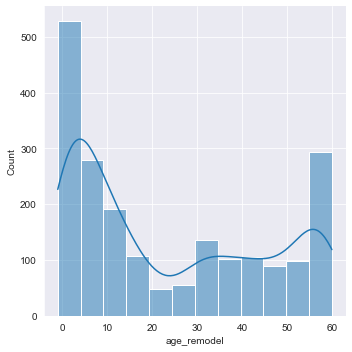

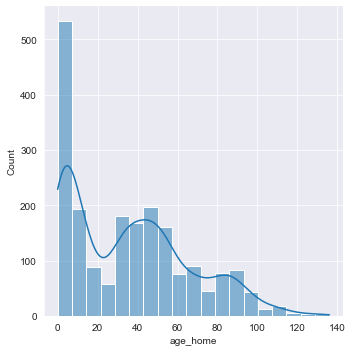

In [72]:
# Quick glance at our features after outliers have been removed
for col in list(feat_kept.index):
    sns.displot(data=train, x=col, kde=True)
    plt.show()

### Log-transforming right-skewed quantiative features

In [73]:
train_d['gr_liv_area'] = np.log1p(train_d['gr_liv_area'])
test_d['gr_liv_area'] = np.log1p(test_d['gr_liv_area'])

In [74]:
train_d['garage_area'] = np.log1p(train_d['garage_area'])
test_d['garage_area'] = np.log1p(test_d['garage_area'])

In [75]:
train_d['total_bsmt_sf'] = np.log1p(train_d['total_bsmt_sf'])
test_d['total_bsmt_sf'] = np.log1p(test_d['total_bsmt_sf'])

In [76]:
train_d['mas_vnr_area'] = np.log1p(train_d['mas_vnr_area'])
test_d['mas_vnr_area'] = np.log1p(test_d['mas_vnr_area'])

In [77]:
train_d['1st_flr_sf'] = np.log1p(train_d['1st_flr_sf'])
test_d['1st_flr_sf'] = np.log1p(test_d['1st_flr_sf'])

In [78]:
train_d['wood_deck_sf'] = np.log1p(train_d['wood_deck_sf'])
test_d['wood_deck_sf'] = np.log1p(test_d['wood_deck_sf'])

In [79]:
train_d['bsmtfin_sf_1'] = np.log1p(train_d['bsmtfin_sf_1'])
test_d['bsmtfin_sf_1'] = np.log1p(test_d['bsmtfin_sf_1'])

In [80]:
train_d['open_porch_sf'] = np.log1p(train_d['open_porch_sf'])
test_d['open_porch_sf'] = np.log1p(test_d['open_porch_sf'])

In [81]:
train_d['lot_frontage'] = np.log1p(train_d['lot_frontage'])
test_d['lot_frontage'] = np.log1p(test_d['lot_frontage'])

In [82]:
train_d['lot_area'] = np.log1p(train_d['lot_area'])
test_d['lot_area'] = np.log1p(test_d['lot_area'])

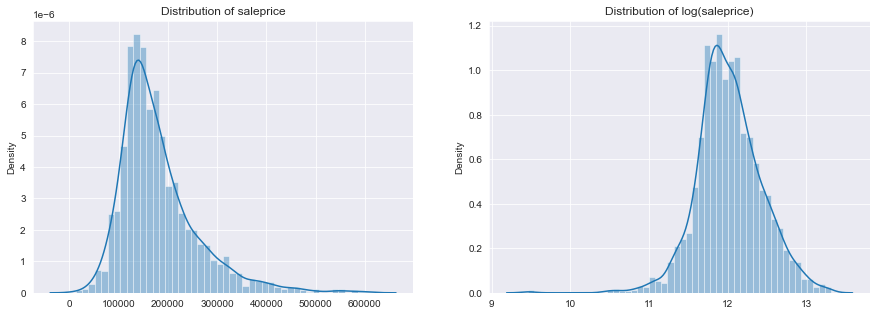

In [83]:
# Visualising our target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(ax=axes[0], x=train['saleprice'], kde=True)
axes[0].set_title("Distribution of saleprice")

sns.distplot(ax=axes[1], x=np.log1p(train['saleprice']), kde=True)
axes[1].set_title("Distribution of log(saleprice)")
plt.show()

## Defining our variables

In [84]:
# Definition of X and y variables
X = train_d.drop(columns=['saleprice'])
y = np.log(train_d['saleprice'])

In [85]:
# Splitting our train dataset into separate train and test subsets to train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

## Baseline

We will use the average of our train split's saleprice to predict the test split's saleprice. This will help us illustrate the significant improvement in predictions via other methods.

In [86]:
# Compute predictions (test split) by using the average of saleprice values from our train split
y_baseline_pred = [np.mean(np.exp(y_train)) for i in range(len(y_test))]
y_baseline_pred[:5]

[182926.1337704918,
 182926.1337704918,
 182926.1337704918,
 182926.1337704918,
 182926.1337704918]

### $R^2$ scores (Baseline)

In [87]:
# Lets compute our R-squared scores for our baseline model
base_r2_testsplit = metrics.r2_score(np.exp(y_test), y_baseline_pred)
base_r2_testsplit

-0.010517656452443402

$R^2$ compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). If the chosen model fits worse than a horizontal line, then $R^2$ is negative. Note that $R^2$ is not always the square of anything, so it can have a negative value without violating any rules of math. $R^2$ is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

**Bottom-line: This confirms our suspicion that this is a crappy model**

### RMSE (Baseline)

In [88]:
# Computing baseline residuals
base_residuals = np.exp(y_test) - y_baseline_pred

<Figure size 720x360 with 0 Axes>

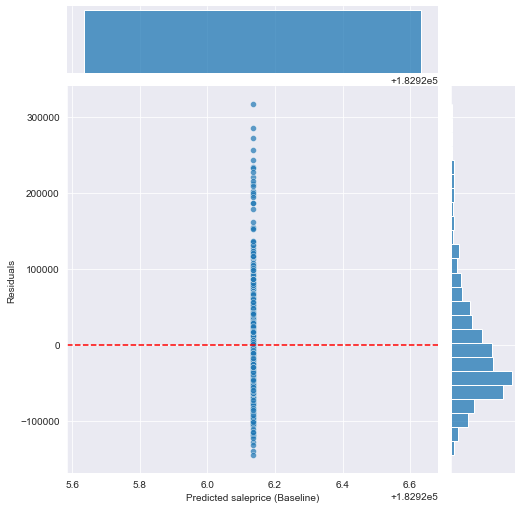

In [119]:
# Visualising our baseline residuals
plt.figure(figsize=(10,5))

g = sns.jointplot(x=y_baseline_pred, y=base_residuals, alpha=0.7, height=7, ratio=5)
g.ax_joint.axhline(0, ls="--", c='red')
g.ax_joint.set(xlabel = 'Predicted saleprice (Baseline)', ylabel='Residuals')
plt.show()

In [90]:
# Lets compute our RMSE; The aim is to get RMSE as close to 0 as possible
baseline_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), y_baseline_pred))
baseline_rmse

73309.4948743501

In [91]:
# Lets compute our MAE; The aim is to get MAE as close to 0 as possible
baseline_mae = metrics.mean_absolute_error(np.exp(y_test), y_baseline_pred)
baseline_mae

55817.79161454477

In calculating the RMSE. We have chosen to convert our predictions back to nominal saleprice values as the metric is dependant on the scale of Y. We will need to compare this figure later.

## Linear Regression

Let's start with the simplest form of supervised machine learning (Linear Regression)

In [92]:
# Instantiating Linear Regression model
lr = LinearRegression()

### $R^2$ scores (Linear Regression)

In [93]:
# Using cross_val_score with 5 folds for our train split
cross_val_score(lr, X_train, y_train, cv=10).mean()

0.898506278717859

In [94]:
# Using cross_val_score with 5 folds for our test split
lr_r2_testsplit = cross_val_score(lr, X_test, y_test, cv=5).mean()
lr_r2_testsplit

0.8734145775831428

### RMSE (Linear Regression)

In [95]:
# Let's fit the model to the entire train set and see what predictions we'll churn out
lr.fit(X_train, y_train)

LinearRegression()

In [96]:
# Churning our predictions for the actual test set
lr_train_pred = lr.predict(X_test)

In [97]:
# Calculating model residuals
lr_residuals = np.exp(y_test) - np.exp(lr_train_pred)

<Figure size 720x360 with 0 Axes>

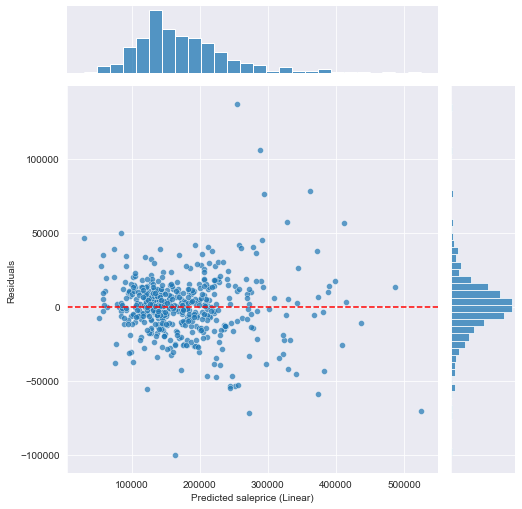

In [120]:
# Visualising our linear regression model residuals
plt.figure(figsize=(10,5))

g = sns.jointplot(x=np.exp(lr_train_pred), y=lr_residuals, alpha=0.7, height=7, ratio=5)
g.ax_joint.axhline(0, ls="--", c='red')
g.ax_joint.set(xlabel = 'Predicted saleprice (Linear)', ylabel='Residuals')
plt.show()

In [99]:
# Computing RMSE for our linear regression model
lr_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(lr_train_pred)))
lr_rmse

20718.466433309117

In [100]:
# Computing MAE for our linear regression model
lr_mae = metrics.mean_absolute_error(np.exp(y_test), np.exp(lr_train_pred))
lr_mae

14091.24001693285

With that done, let's move on to the next model we've selected - Ridge regression

*Note: We will provide a summary table to evaluate our models later*

## Ridge Regression

We'll need to standardize our features here. Since we are adding a loss function (with penalty) in Ridge and Lasso regressions, scaling is required so that **regularization penalises each variable equally fairly**

In [101]:
# Instantiating Standard Scaler
ss = StandardScaler()

**Standardization does not change the skew of the distribution.** What it does is to transform the values so that the overall distribution has $μ$ = 0 and $σ^2$ = 1. The shape of the actual distribution remains unchanged.

Many elements used in the objective function of a learning algorithm assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

When a feature does not follow a linear distribution, it would be unwise to use the mean and the standard deviation to scale it. **Log-transformation changes the skew of the distribution, and is useful when you deal with right-skewed distributions (fat right tails).** 

*This is why we transformed some of our features earlier*

In [102]:
# Scaling our features for our train/test splits of the train set
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [103]:
# We then scale our features for our test set
Z_full_train = ss.fit_transform(X)
Z_test_d = ss.transform(test_d)

In [104]:
# Instantiating Ridge regression with "built-in" cross-validation
# We will also set up a list of ridge alphas for the model to select for

# We will then cross-validate over our list of ridge alphas
ridge = RidgeCV(cv=10, scoring='r2', alphas=np.linspace(0, 10, 100))

In [105]:
# Fitting our model to our train split for our train set
ridge.fit(Z_train, y_train)

RidgeCV(alphas=array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303...
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96969697,
        7.07070707,  7.17171717,  7.27272727,  7.37373737,  7.47474747,
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ]),
        cv=10, scoring='r

In [106]:
# What is our optimal value of alpha from our RidgeCV?
ridge.alpha_

10.0

### $R^2$ scores (Ridge Regression)

In [107]:
# How does ridge regression fare here?
ridge.score(Z_train, y_train)

0.933262816266314

In [108]:
# Let's fit and score our model to the test split for our train set
ridge_r2_testsplit = ridge.score(Z_test, y_test)
ridge_r2_testsplit

0.9003197184300739

Our $R^2$ scores for our train/test splits are higher compared to the Linear regression model we built previously.

### RMSE (Ridge Regression)

In [109]:
# Generating predictions for the test split of our train set
ridge_train_pred = ridge.predict(Z_test)

In [110]:
# Calculating model residuals
ridge_residuals = np.exp(y_test) - np.exp(ridge_train_pred)

<Figure size 720x360 with 0 Axes>

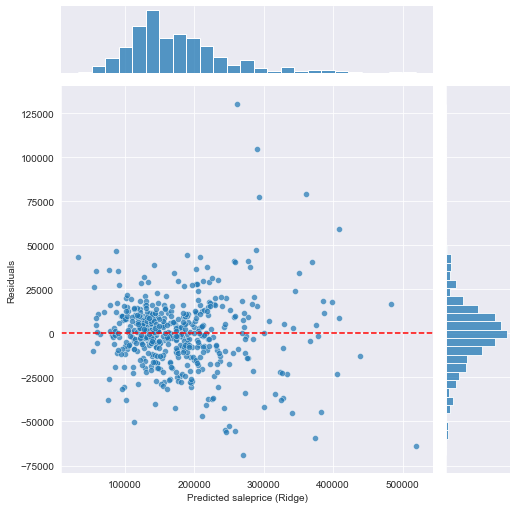

In [121]:
# Visualising our ridge model residuals
plt.figure(figsize=(10,5))

g = sns.jointplot(x=np.exp(ridge_train_pred), y=ridge_residuals, alpha=0.7, height=7, ratio=5)
g.ax_joint.axhline(0, ls="--", c='red')
g.ax_joint.set(xlabel = 'Predicted saleprice (Ridge)', ylabel='Residuals')
plt.show()

In [122]:
# Computing RMSE using metrics
ridge_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(ridge_train_pred)))
ridge_rmse

20024.019375500637

### MAE (Ridge Regression)

In [123]:
# Computing MAE
ridge_mae = metrics.mean_absolute_error(np.exp(y_test), np.exp(ridge_train_pred))
ridge_mae

13836.775735878347

The metrics we've gleaned from our Ridge Regression model appear to be a marginal improvement over our Linear Regression model. Let's now take a look at Lasso Regression.

## Lasso Regression

We will also set up a list of laso alphas to check through

In [124]:
# np.logspace generates 200 values equally between -5 and 2
l_alphas = np.logspace(-5,2,200)

In [125]:
# Instantiating Lasso regression with "built-in" cross-validation
# We will then cross-validate over our list of ridge alphas
lasso = LassoCV(cv=10, alphas=l_alphas, max_iter=50000)

In [126]:
lasso.fit(Z_train, y_train)

LassoCV(alphas=array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-05,
       2.64308149e-05, 2.86606762e-05, 3.10786619e-05, 3.37006433e-05,
       3.65438307e-05, 3.96268864e-05, 4.29700470e-05, 4.65952567e-05,
       5.05263107e-05, 5.47890118e-0...
       1.55222536e+01, 1.68318035e+01, 1.82518349e+01, 1.97916687e+01,
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
        cv=10, max_iter=50000)

In [127]:
# What is the optimal alpha for our Lasso Regression model?
lasso.alpha_

0.0022739657523579274

### $R^2$  scores (Lasso Regression)

In [128]:
# How does lasso regression fare here?
lasso.score(Z_train, y_train)

0.9260118020687953

In [129]:
# Let's fit and score our model to the test split for our train set
lasso_r2_testsplit = lasso.score(Z_test, y_test)
lasso_r2_testsplit

0.9084160602047073

### RMSE (Lasso Regression)

In [130]:
# Generating predictions for the test split of our train set
lasso_train_pred = lasso.predict(Z_test)

In [131]:
# Calculating model residuals
lasso_residuals = np.exp(y_test) - np.exp(lasso_train_pred)

<Figure size 720x360 with 0 Axes>

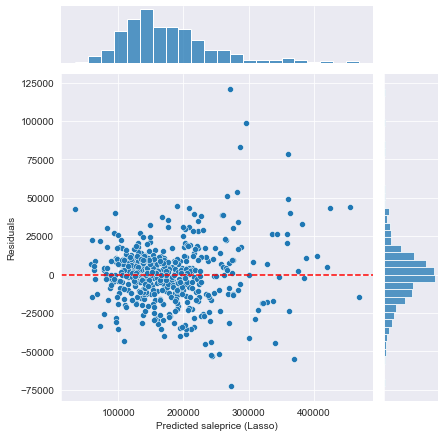

In [132]:
# Visualising our lasso model residuals
plt.figure(figsize=(10,5))

g = sns.jointplot(x=np.exp(lasso_train_pred), y=lasso_residuals)
g.ax_joint.axhline(0, ls="--", c='red')
g.ax_joint.set(xlabel = 'Predicted saleprice (Lasso)', ylabel='Residuals')
plt.show()

In [133]:
# Computing RMSE using metrics
lasso_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(lasso_train_pred)))
lasso_rmse

19566.67133509104

In [134]:
# Computing MAE using metrics
lasso_mae = metrics.mean_absolute_error(np.exp(y_test), np.exp(lasso_train_pred))
lasso_mae

13697.663699508008

The metrics we've gleaned from our Lasso Regression model are comparable to our Ridge Regression model. Howwever, the Lasso model gives more favourable $R^2$ scores and RMSE scores for the test split.

# Model Evaluation / Selection

In [135]:
from prettytable import PrettyTable

In [136]:
# Create dataframe in case we need to do some charting
evaluation = pd.DataFrame()
evaluation['model'] = ['baseline', 'linear', 'ridge', 'lasso']
evaluation['r2_score'] = [base_r2_testsplit, lr_r2_testsplit, 
                          ridge_r2_testsplit, lasso_r2_testsplit]
evaluation['rmse'] = [baseline_rmse, lr_rmse, 
                      ridge_rmse, lasso_rmse]
evaluation['mae'] = [baseline_mae, lr_mae, 
                      ridge_mae, lasso_mae]

In [137]:
# Let's create a pretty table
t = PrettyTable(['Model', 'R2 scores', 'RMSE', 'MAE', 'Selection'])
t.add_row(['Baseline (Mean)', round(base_r2_testsplit, 4), round(baseline_rmse,2), round(baseline_mae,2),''])
t.add_row(['Linear Regression', round(lr_r2_testsplit, 4), round(lr_rmse, 2), round(lr_mae,2), ''])
t.add_row(['Ridge Regression', round(ridge_r2_testsplit, 4), round(ridge_rmse, 2), round(ridge_mae, 2), ''])
t.add_row(['Lasso Regression', round(lasso_r2_testsplit, 4), round(lasso_rmse, 2), round(lasso_mae, 2), '*'])
print(t)

+-------------------+-----------+----------+----------+-----------+
|       Model       | R2 scores |   RMSE   |   MAE    | Selection |
+-------------------+-----------+----------+----------+-----------+
|  Baseline (Mean)  |  -0.0105  | 73309.49 | 55817.79 |           |
| Linear Regression |   0.8734  | 20718.47 | 14091.24 |           |
|  Ridge Regression |   0.9003  | 20024.02 | 13836.78 |           |
|  Lasso Regression |   0.9084  | 19566.67 | 13697.66 |     *     |
+-------------------+-----------+----------+----------+-----------+


# Model Selection

In [138]:
# Training model on full train dataset
lasso.fit(Z_full_train, y)

LassoCV(alphas=array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-05,
       2.64308149e-05, 2.86606762e-05, 3.10786619e-05, 3.37006433e-05,
       3.65438307e-05, 3.96268864e-05, 4.29700470e-05, 4.65952567e-05,
       5.05263107e-05, 5.47890118e-0...
       1.55222536e+01, 1.68318035e+01, 1.82518349e+01, 1.97916687e+01,
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
        cv=10, max_iter=50000)

The LassoCV model appears to be doing the best based on $R^2$ scoring confirmation from our cross validation, so let's go  with that model for now.

Let's now fit the LassoCV model to the entire training dataset and make predictions below:


In [139]:
# Generate saleprice predictions using our Lasso Regression model
lasso_pred = np.exp(lasso.predict(Z_test_d))

In [140]:
# Lets get the regression coefficients for features used in the model
lasso_model_coefs = lasso.coef_
print(lasso_model_coefs)

[ 0.09843795  0.11449424  0.          0.02461266  0.01443149  0.02840708
  0.00159011  0.          0.          0.01664278  0.0447143   0.00490634
  0.00260642  0.00683649  0.04570246 -0.03740112 -0.03154456  0.00635487
  0.00273355  0.         -0.          0.         -0.          0.00392331
  0.00142333 -0.          0.01599391 -0.00840074 -0.00111186  0.
 -0.006427   -0.00448045 -0.          0.          0.00137528 -0.
  0.00950563  0.01726249 -0.01161221  0.          0.         -0.00234037
  0.01054215  0.01148347  0.         -0.          0.          0.0123276
  0.00489828  0.00653018 -0.0017201  -0.         -0.         -0.
 -0.          0.          0.         -0.         -0.         -0.
  0.         -0.00200031 -0.01002779 -0.00135992 -0.00325914  0.
 -0.         -0.          0.00031431 -0.          0.00386894 -0.00104654
  0.          0.          0.         -0.          0.          0.00295858
  0.         -0.00171702  0.01179718 -0.          0.00281397 -0.
 -0.          0.00306581 -0

In [141]:
# Creation of dataframe to house our model coefficients
lasso_coef_df = pd.DataFrame()
lasso_coef_df['features'] = X.columns
lasso_coef_df['coefs'] = lasso_model_coefs

In [142]:
# Extracting the largest 5 (+/-) coefficients
top5 = lasso_coef_df.sort_values('coefs').head(5)
btm5 = lasso_coef_df.sort_values('coefs').tail(5)

topfeats = pd.concat([top5, btm5], axis=0)
topfeats

,features,coefs
15,age_remodel,-0.037401
16,age_home,-0.031545
154,kitchen_qual_TA,-0.024304
159,functional_Sal,-0.021414
152,kitchen_qual_Gd,-0.019111
5,1st_flr_sf,0.028407
10,bsmtfin_sf_1,0.044714
14,lot_area,0.045702
0,overall_qual,0.098438
1,gr_liv_area,0.114494


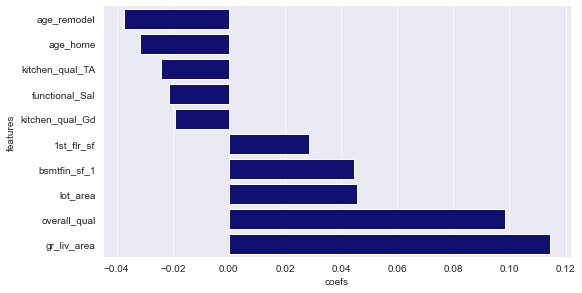

In [145]:
# Charting the largest coefficients of our Lasso regression model
sns.catplot(data=topfeats, y='features', x='coefs', 
            kind='bar', color='navy', height=4, aspect=2)

plt.show()

## Submission to Kaggle

In [ ]:
# submission = pd.DataFrame()
# submission['Id'] = test['id']
# submission['SalePrice'] = lasso_pred

In [ ]:
# submission.to_csv('./datasets/submission_lasso_27.csv', index=False)